In [1]:
# Import der Bibliotheken

import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date, datetime
import plotly

In [2]:
# Konfiguration der Grafiken

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.autolayout'] = False

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


# Definition von Funktionen

In [3]:
# Funktion zur Abbildung des Jahresverlaufs

def Jahresverlauf (Titel, Zeitstempel, Leistung, xlabel, ylabel):

  fig = plt.figure(figsize=(19,8))

 

  ax1 = fig.add_axes([1, 1, 1, 1])
  ax1.set_title(Titel,weight='bold',fontsize=15)
  ax1.plot(Zeitstempel,Leistung,c='green')
  plt.xlabel(xlabel,fontsize=15 )
  plt.ylabel(ylabel,fontsize=15)

 

  plt.show()

In [4]:
# Funktion zur Abbildung der Jahresdauerlinie

def Dauerlinie (Dataframe, Column, Titel,Yachse ):
  df_sort = Dataframe.sort_values(by=[Column], ascending=False) # sortieren der Wirkleistungen in absteigender Reihenfolge
  df_sort = df_sort.reset_index(drop=True) #zurücksetzen des Index
  plt.plot(df_sort.index, df_sort[Column]) # Plotten der Dauerlinie
  plt.title(Titel)
  plt.ylabel(Yachse)

In [5]:
# Auswahl des Standortes
location_north = False

# Einlesen der Datenreihen

In [6]:
# Erzeugungsprofile

if location_north:
    data_pv = pd.read_csv('data/data_pv_antofagasta_1MW.csv', skiprows = 3)
    data_wind = pd.read_csv('data/data_wind_antofagasta_1MW.csv', skiprows = 3)
    
else:
    data_pv = pd.read_csv('data/data_pv_punta_arenas_1MW.csv', skiprows = 3)
    data_wind = pd.read_csv('data/data_wind_punta_arenas_1MW.csv', skiprows = 3)
    
data_shipping = pd.read_excel('data/Ferntransport.xlsx', usecols = (0,1))

In [7]:
# Erstellung eines Dataframes aus externen Daten

dataset_df=pd.DataFrame()
dataset_df['Zeitstempel']=data_pv['time']
dataset_df['PV_Erzeugung']=data_pv['electricity']
dataset_df['Wind_Erzeugung']=data_wind['electricity']

if location_north:
    dataset_df['Kapazität_Schiff']=data_shipping['Antofagasta']
else:
    dataset_df['Kapazität_Schiff']=data_shipping['Punta Arenas']
    
dataset_df.Kapazität_Schiff=dataset_df.Kapazität_Schiff.fillna(method='ffill')

In [8]:
# Einlesen und Ausgabe der Inputs für die Variablen

data_inputs = pd.read_excel('data/Inputs_Modell.xlsx', sheet_name = 'Gesamt', header = 2, index_col = 0, nrows = 20)

data_inputs=pd.DataFrame(data_inputs.fillna(0)).drop(columns = ['Unnamed: 1','name','bus','p_nom','Unnamed: 10','Unnamed: 11'])
data_inputs

,marginal_cost,lifetime,capital_cost,efficiency,standing_loss
NaN,static,float,float,float,float
Photovoltaik (Chile),27.12247,30,1005225.25,n.v.,n.v.
Windkraft (Chile),25.30435,30,1178290,n.v.,n.v.
Entsalzung,0.008161,20,1213.497969,1,n.v.
PEM Elektrolyse,2.885636,10,720000,0.598911,n.v.
AEL Elektrolyse,3.661555,10,630000,0.617978,n.v.
Verflüssigung,0,20,3296969.69697,0.767442,n.v.
Haber-Bosch,0,20,1212000,0.92,n.v.
Hydrierung,0,20,79500,0.7,n.v.
Stromspeicher,0,30,1095.66909,n.v.,0


# Definition der Variablen

In [9]:
# Erstellung der Last durch den Wasserstoffbedarf

hydrogen_energy_content = 33 #kWh/kg oder MWh/t
hydrogen_demand_t = 35 * 1000
hydrogen_demand_kg = hydrogen_demand_t * 1000
hydrogen_demand_MWh = hydrogen_demand_t * hydrogen_energy_content # MWh
hydrogen_demand_hourly = hydrogen_demand_MWh/8760 #MW

print('Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr ' + str(round(hydrogen_demand_hourly,0)) + ' MWh')

Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr 132.0 MWh


## Investitionskosten

In [10]:
# capital_cost

# Erzeugung
capital_cost_pv = data_inputs.loc['Photovoltaik (Chile)']['capital_cost'] # €/MW
capital_cost_wind = data_inputs.loc['Windkraft (Chile)']['capital_cost'] # €/MW


# Elektrolyse
capital_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['capital_cost'] # €/MW
capital_cost_AEL = data_inputs.loc['AEL Elektrolyse']['capital_cost'] # €/MW


# Umwandlung
capital_cost_LH2 = data_inputs.loc['Verflüssigung']['capital_cost'] # €/MW
capital_cost_NH3 = data_inputs.loc['Haber-Bosch']['capital_cost'] # €/MW
capital_cost_LOHC = data_inputs.loc['Hydrierung']['capital_cost'] # €/MW
capital_cost_LH2_b = data_inputs.loc['Regasifizierung']['capital_cost'] # €/MW
capital_cost_NH3_b = data_inputs.loc['NH3 Cracker']['capital_cost'] # €/MW
capital_cost_LOHC_b = data_inputs.loc['Dehydrierung']['capital_cost'] # €/MW


#Transport
capital_cost_pipeline = data_inputs.loc['Pipeline']['capital_cost'] # €/MW
capital_cost_shipping_LH2 = data_inputs.loc['LH2 Schiff']['capital_cost'] # €/MW
capital_cost_shipping_NH3 = data_inputs.loc['NH3 Schiff']['capital_cost'] # €/MW
capital_cost_shipping_LOHC = data_inputs.loc['LOHC Schiff']['capital_cost'] # €/MW


# Speicherung
capital_cost_storage_el = data_inputs.loc['Stromspeicher']['capital_cost']
capital_cost_storage_LH2 = data_inputs.loc['LH2 Speicher']['capital_cost'] # €/MW
capital_cost_storage_NH3 = data_inputs.loc['NH3 Speicher']['capital_cost'] # €/MW
capital_cost_storage_LOHC = data_inputs.loc['LOHC Speicher']['capital_cost'] # €/MW

## Gestehungskosten

In [11]:
# marginal_cost

# Erzeugung
marginal_cost_pv = data_inputs.loc['Photovoltaik (Chile)']['marginal_cost'] # €/MWh
marginal_cost_wind = data_inputs.loc['Windkraft (Chile)']['marginal_cost'] # €/MWh

# Elektrolyse
marginal_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['marginal_cost'] # €/MWh
marginal_cost_AEL = data_inputs.loc['AEL Elektrolyse']['marginal_cost'] # €/MWh

# Umwandlung
marginal_cost_LH2 = data_inputs.loc['Verflüssigung']['marginal_cost'] # €/MWh
marginal_cost_NH3 = data_inputs.loc['Haber-Bosch']['marginal_cost'] # €/MWh
marginal_cost_LOHC = data_inputs.loc['Hydrierung']['marginal_cost'] # €/MWh
marginal_cost_LH2_b = data_inputs.loc['Regasifizierung']['marginal_cost'] # €/MWh
marginal_cost_NH3_b = data_inputs.loc['NH3 Cracker']['marginal_cost'] # €/MWh
marginal_cost_LOHC_b = data_inputs.loc['Dehydrierung']['marginal_cost'] # €/MWh

# Transport
marginal_cost_pipeline = data_inputs.loc['Pipeline']['marginal_cost'] # €/MWh
marginal_cost_shipping_LH2 = data_inputs.loc['LH2 Schiff']['marginal_cost'] # €/MWh
marginal_cost_shipping_NH3 = data_inputs.loc['NH3 Schiff']['marginal_cost'] # €/MWh
marginal_cost_shipping_LOHC = data_inputs.loc['LOHC Schiff']['marginal_cost'] # €/MWh

# Speicherung
marginal_cost_storage_el = data_inputs.loc['Stromspeicher']['marginal_cost'] # €/MWh
marginal_cost_storage_LH2 = data_inputs.loc['LH2 Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_NH3 = data_inputs.loc['NH3 Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_LOHC = data_inputs.loc['LOHC Speicher']['marginal_cost'] # €/MWh

## Effizienz

In [12]:
# efficiency

# Wirkungsgrad Erzeugung
efficiency_PEMEL = data_inputs.loc['PEM Elektrolyse']['efficiency']
efficiency_AEL = data_inputs.loc['AEL Elektrolyse']['efficiency']

# Wirkungsgrad Umwandlung
efficiency_LH2 = data_inputs.loc['Verflüssigung']['efficiency']
efficiency_NH3 = data_inputs.loc['Haber-Bosch']['efficiency']
efficiency_LOHC = data_inputs.loc['Hydrierung']['efficiency']

efficiency_LH2_b = data_inputs.loc['Regasifizierung']['efficiency']
efficiency_NH3_b = data_inputs.loc['NH3 Cracker']['efficiency']
efficiency_LOHC_b = data_inputs.loc['Dehydrierung']['efficiency']

# Wirkungsgrad der Transporte
efficiency_shipping_LH2 = data_inputs.loc['LH2 Schiff']['efficiency'] 
efficiency_shipping_NH3 = data_inputs.loc['NH3 Schiff']['efficiency']
efficiency_shipping_LOHC = data_inputs.loc['LOHC Schiff']['efficiency']


# Speicherverluste
standing_loss_el = 0.1 # data_inputs.loc['Stromspeicher']['standing_loss']
standing_loss_LH2 = 0.002/24 # data_inputs.loc['LH2 Speicher']['standing_loss']
standing_loss_NH3 = data_inputs.loc['NH3 Speicher']['standing_loss']
standing_loss_LOHC = data_inputs.loc['LOHC Speicher']['standing_loss']

## Lebenszeit

In [13]:
# lifetime

lifetime_pv = data_inputs.loc['Photovoltaik (Chile)']['lifetime']
lifetime_wind = data_inputs.loc['Windkraft (Chile)']['lifetime']

lifetime_PEMEL = data_inputs.loc['PEM Elektrolyse']['lifetime']
lifetime_AEL = data_inputs.loc['AEL Elektrolyse']['lifetime']

lifetime_LH2 = data_inputs.loc['Verflüssigung']['lifetime']
lifetime_NH3 = data_inputs.loc['Haber-Bosch']['lifetime']
lifetime_LOHC = data_inputs.loc['Hydrierung']['lifetime']

lifetime_LH2_b = data_inputs.loc['Regasifizierung']['lifetime']
lifetime_NH3_b = data_inputs.loc['NH3 Cracker']['lifetime']
lifetime_LOHC_b = data_inputs.loc['Dehydrierung']['lifetime']

lifetime_shipping_LH2 = data_inputs.loc['LH2 Schiff']['lifetime'] 
lifetime_shipping_NH3 = data_inputs.loc['NH3 Schiff']['lifetime']
lifetime_shipping_LOHC = data_inputs.loc['LOHC Schiff']['lifetime']

lifetime_pipeline = 1 # data_inputs.loc['Pipeline']['lifetime']

lifetime_storage_el = data_inputs.loc['Stromspeicher']['lifetime']
lifetime_storage_LH2 = data_inputs.loc['LH2 Speicher']['lifetime']
lifetime_storage_NH3 = data_inputs.loc['NH3 Speicher']['lifetime']
lifetime_storage_LOHC = data_inputs.loc['LOHC Speicher']['lifetime']

# Netzwerke aufbauen

In [14]:
#Erzeugung der drei Netzwerke

network1 = pypsa.Network()
network2 = pypsa.Network()
network3 = pypsa.Network()

# Einstellung der Snapshots

network1.set_snapshots(range(8760))
network2.set_snapshots(range(8760))
network3.set_snapshots(range(8760))

## Buses

In [15]:
# Erzeugung der Knotenpunkte

# Der Suffix _b steht für Bremerhaven
# Der Suffix _c steht für Chile
    
network1.add('Bus', name = 'electricity')
network1.add('Bus', name = 'GH2_b')
network1.add('Bus', name = 'GH2_c')
network1.add('Bus', name = 'cologne')
network1.add('Bus', name = 'LH2_b')
network1.add('Bus', name = 'LH2_c')

network2.add('Bus', name = 'electricity')
network2.add('Bus', name = 'GH2_b')
network2.add('Bus', name = 'GH2_c')
network2.add('Bus', name = 'cologne')
network2.add('Bus', name = 'NH3_b')
network2.add('Bus', name = 'NH3_c')

network3.add('Bus', name = 'electricity')
network3.add('Bus', name = 'GH2_b')
network3.add('Bus', name = 'GH2_c')
network3.add('Bus', name = 'cologne')
network3.add('Bus', name = 'LOHC_b')
network3.add('Bus', name = 'LOHC_c')

## Loads

In [16]:
network1.add('Load', name = 'hydrogen_demand', bus = 'cologne', 
            p_set = hydrogen_demand_hourly)

network2.add('Load', name = 'hydrogen_demand', bus = 'cologne', 
            p_set = hydrogen_demand_hourly)

network3.add('Load', name = 'hydrogen_demand', bus = 'cologne', 
            p_set = hydrogen_demand_hourly)

## Generators

In [17]:
network1.add('Generator', name = 'Photovoltaik', bus = 'electricity', 
             p_max_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
             p_min_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
             p_nom_extendable = True,
             marginal_cost = marginal_cost_pv, 
             capital_cost = capital_cost_pv,
            lifetime = lifetime_pv)
network1.add('Generator', name = 'Windkraft', bus = 'electricity',
             p_max_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
             p_min_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
             p_nom_extendable = True,
             marginal_cost = marginal_cost_wind, 
             capital_cost = capital_cost_wind,
            lifetime = lifetime_wind)

network2.add('Generator', name = 'Photovoltaik', bus = 'electricity', 
             p_max_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
             p_min_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
             p_nom_extendable = True,
             marginal_cost = marginal_cost_pv, 
             capital_cost = capital_cost_pv,
            lifetime = lifetime_pv)
network2.add('Generator', name = 'Windkraft', bus = 'electricity',
             p_max_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
             p_min_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
             p_nom_extendable = True,
             marginal_cost = marginal_cost_wind, 
             capital_cost = capital_cost_wind,
            lifetime = lifetime_wind)

network3.add('Generator', name = 'Photovoltaik', bus = 'electricity', 
             p_max_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
             p_min_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
             p_nom_extendable = True,
             marginal_cost = marginal_cost_pv, 
             capital_cost = capital_cost_pv,
            lifetime = lifetime_pv)
network3.add('Generator', name = 'Windkraft', bus = 'electricity',
             p_max_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
             p_min_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
             p_nom_extendable = True,
             marginal_cost = marginal_cost_wind, 
             capital_cost = capital_cost_wind,
            lifetime = lifetime_wind)

## Links - Electrolysis

In [18]:
network1.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                lifetime = lifetime_PEMEL,
                marginal_cost = marginal_cost_PEMEL, 
                capital_cost = capital_cost_PEMEL,
                efficiency = efficiency_PEMEL)
network1.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                lifetime = lifetime_AEL,
                marginal_cost = marginal_cost_AEL, 
                capital_cost = capital_cost_AEL,
                efficiency = efficiency_AEL)

network2.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                lifetime = lifetime_PEMEL,
                marginal_cost = marginal_cost_PEMEL, 
                capital_cost = capital_cost_PEMEL,
                efficiency = efficiency_PEMEL)    
network2.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                lifetime = lifetime_AEL,
                marginal_cost = marginal_cost_AEL, 
                capital_cost = capital_cost_AEL,
                efficiency = efficiency_AEL)

network3.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                lifetime = lifetime_PEMEL,
                marginal_cost = marginal_cost_PEMEL, 
                capital_cost = capital_cost_PEMEL,
                efficiency = efficiency_PEMEL)    
network3.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                lifetime = lifetime_AEL,
                marginal_cost = marginal_cost_AEL, 
                capital_cost = capital_cost_AEL,
                efficiency = efficiency_AEL)

## Links - Conversion

In [19]:
network1.add('Link', name = 'Verflüssigung', bus0 = 'GH2_c', bus1 = 'LH2_c',
             p_nom_extendable = True,
             marginal_cost = marginal_cost_LH2, 
             capital_cost = capital_cost_LH2,
             efficiency = efficiency_LH2,
             lifetime = lifetime_LH2)
network1.add('Link', name = 'Regasifizierung', bus0 = 'LH2_b', bus1 = 'GH2_b',
             p_nom_extendable = True,
             marginal_cost = marginal_cost_LH2_b, 
             capital_cost = capital_cost_LH2_b,
             efficiency = efficiency_LH2_b,
             lifetime = lifetime_LH2_b)

network2.add('Link', name = 'Haber-Bosch', bus0 = 'GH2_c', bus1 = 'NH3_c',
             p_nom_extendable = True,
             marginal_cost = marginal_cost_NH3, 
             capital_cost = capital_cost_NH3,
             efficiency = efficiency_NH3,
             lifetime = lifetime_NH3)
network2.add('Link', name = 'NH3 Cracker', bus0 = 'NH3_b', bus1 = 'GH2_b',
             p_nom_extendable = True,
             marginal_cost = marginal_cost_NH3_b, 
             capital_cost = capital_cost_NH3_b,
             efficiency = efficiency_NH3_b,
             lifetime = lifetime_NH3_b)

network3.add('Link', name = 'Hydrierung', bus0 = 'GH2_c', bus1 = 'LOHC_c',
             p_nom_extendable = True,
             marginal_cost = marginal_cost_LOHC, 
             capital_cost = capital_cost_LOHC,
             efficiency = efficiency_LOHC,
             lifetime = lifetime_LOHC)
network3.add('Link', name = 'Dehydrierung', bus0 = 'LOHC_b', bus1 = 'GH2_b',
             p_nom_extendable = True,
             marginal_cost = marginal_cost_LOHC_b, 
             capital_cost = capital_cost_LOHC_b,
             efficiency = efficiency_LOHC_b,
             lifetime = lifetime_LOHC_b)

## Links - Cargoship

In [20]:
network1.add('Link', name = 'Verschiffung LH2', bus0 = 'LH2_c', bus1 = 'LH2_b',
             p_nom = dataset_df['Kapazität_Schiff'].max(),
             p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
             p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
             p_nom_extendable = True,
             marginal_cost = marginal_cost_shipping_LH2, 
             capital_cost = capital_cost_shipping_LH2,
             efficiency = efficiency_shipping_LH2)

network2.add('Link', name = 'Verschiffung NH3', bus0 = 'NH3_c', bus1 = 'NH3_b',
             p_nom = dataset_df['Kapazität_Schiff'].max(),
             p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
             p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
             p_nom_extendable = True,
             marginal_cost = marginal_cost_shipping_NH3, 
             capital_cost = capital_cost_shipping_NH3,
             efficiency = efficiency_shipping_NH3)
    
network3.add('Link', name = 'Verschiffung LOHC', bus0 = 'LOHC_c', bus1 = 'LOHC_b',
             p_nom = dataset_df['Kapazität_Schiff'].max(),
             p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
             p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
             p_nom_extendable = True,
             marginal_cost = marginal_cost_shipping_LOHC, 
             capital_cost = capital_cost_shipping_LOHC,
             efficiency = efficiency_shipping_LOHC)

## Links - Pipeline

In [21]:
network1.add('Link', name = 'Pipeline', bus0 = 'GH2_b', bus1 = 'cologne', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pipeline, 
            capital_cost = capital_cost_pipeline,
            lifetime = lifetime_pipeline)

network2.add('Link', name = 'Pipeline', bus0 = 'GH2_b', bus1 = 'cologne', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pipeline, 
            capital_cost = capital_cost_pipeline,
            lifetime = lifetime_pipeline)

network3.add('Link', name = 'Pipeline', bus0 = 'GH2_b', bus1 = 'cologne', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pipeline, 
            capital_cost = capital_cost_pipeline,
            lifetime = lifetime_pipeline)

## Storages

In [22]:
network1.add('Store', name = 'Stromspeicher', bus = 'electricity', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_el,
            marginal_cost = marginal_cost_storage_el,
            standing_loss = standing_loss_el,
            lifetime = lifetime_storage_el)

network2.add('Store', name = 'Stromspeicher', bus = 'electricity', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_el,
            marginal_cost = marginal_cost_storage_el,
            standing_loss = standing_loss_el,
            lifetime = lifetime_storage_el)

network3.add('Store', name = 'Stromspeicher', bus = 'electricity', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_el,
            marginal_cost = marginal_cost_storage_el,
            standing_loss = standing_loss_el,
            lifetime = lifetime_storage_el)


network1.add('Store', name = 'Flüssigspeicher Chile', bus = 'LH2_c', 
             e_nom_extendable = True, e_cyclic = True,  
             capital_cost = capital_cost_storage_LH2, 
             marginal_cost = marginal_cost_storage_LH2,
             standing_loss = standing_loss_LH2,
             lifetime = lifetime_storage_LH2)
network1.add('Store', name = 'Flüssigspeicher Bremerhaven', bus = 'LH2_b', 
             e_nom_extendable = True, e_cyclic = True,  
             capital_cost = capital_cost_storage_LH2, 
             marginal_cost = marginal_cost_storage_LH2,
             standing_loss = standing_loss_LH2,
             lifetime = lifetime_storage_LH2)

network2.add('Store', name = 'Ammoniakspeicher Chile', bus = 'NH3_c', 
             e_nom_extendable = True,  e_cyclic = True, 
             capital_cost = capital_cost_storage_NH3, 
             marginal_cost = marginal_cost_storage_NH3,
             standing_loss = standing_loss_NH3,
             lifetime = lifetime_storage_NH3)
network2.add('Store', name = 'Ammoniakspeicher Bremerhaven', bus = 'NH3_b', 
             e_nom_extendable = True,  e_cyclic = True, 
             capital_cost = capital_cost_storage_NH3, 
             marginal_cost = marginal_cost_storage_NH3,
             standing_loss = standing_loss_NH3,
             lifetime = lifetime_storage_NH3)
    
network3.add('Store', name = 'LOHC-Speicher Chile', bus = 'LOHC_c', 
             e_nom_extendable = True, e_cyclic = True,  
             capital_cost = capital_cost_storage_LOHC, 
             marginal_cost = marginal_cost_storage_LOHC,
             standing_loss = standing_loss_LOHC,
             lifetime = lifetime_storage_LOHC)
network3.add('Store', name = 'LOHC-Speicher Bremerhaven', bus = 'LOHC_b', 
             e_nom_extendable = True, e_cyclic = True,  
             capital_cost = capital_cost_storage_LOHC, 
             marginal_cost = marginal_cost_storage_LOHC,
             standing_loss = standing_loss_LOHC,
             lifetime = lifetime_storage_LOHC)

# Grafische Darstellung der Ausgangsprofile

In [23]:
#Jahresverlauf('Stromerzeugung aus Windkraft',dataset_df.Zeitstempel.loc[2000:2055], dataset_df['Wind_Erzeugung'].loc[2000:2055],'Zeit','Leistung')

In [24]:
#Jahresverlauf('Stromerzeugung aus Photovoltaik',dataset_df.index, dataset_df['PV_Erzeugung'],'Zeit','Leistung')

In [25]:
#Jahresverlauf('Elektrolyse',dataset_df.index, dataset_df['Elektrolyse'],'Zeit','Leistung')

In [26]:
#Jahresverlauf('Ferntransport',dataset_df.index, dataset_df['Kapazität_Schiff'],'Zeit','Leistung')

# Optimierung des Systems

In [27]:
# Optimierung
network1.lopf(pyomo = False, solver_name = 'gurobi')
network2.lopf(pyomo = False, solver_name = 'gurobi')
network3.lopf(pyomo = False, solver_name = 'gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.23s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-01
Read LP format model from file /var/folders/np/fxyv4bts2s353fj5gdlrbgym0000gn/T/pypsa-problem-dthwwpcv.lp
Reading time = 0.70 seconds
obj: 271560 rows, 122652 columns, 525250 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 271560 rows, 122652 columns and 525250 nonzeros
Model fingerprint: 0x99cbc9d8
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [1e-01, 3e+06]
  Bounds range     [2e+06, 2e+06]
  RHS range        [1e+02, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 200564 rows and 86687 columns
Presolve time: 0.54s
Presolved: 70996 rows, 35965 columns, 220889 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 18
 AA' NZ     : 2.532e+05
 Factor NZ  : 1.135e+

INFO:pypsa.linopf:Optimization successful. Objective value: 3.10e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.19s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/np/fxyv4bts2s353fj5gdlrbgym0000gn/T/pypsa-problem-urg1x4tm.lp
Reading time = 0.65 seconds
obj: 271560 rows, 122652 columns, 525250 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 271560 rows, 122652 columns and 525250 nonzeros
Model fingerprint: 0xcfdc588b
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [6e-02, 1e+06]
  Bounds range     [1e+06, 1e+06]
  RHS range        [1e+02, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 200564 rows and 86687 columns
Presolve time: 0.50s
Presolved: 70996 rows, 35965 columns, 220889 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 18
 AA' NZ     : 2.532e+05
 Factor NZ  : 1.135e+06 (roughly 50 MB of memory)
 Factor Ops : 2.216e+07 (less than 1 second per iteration)
 Th

INFO:pypsa.linopf:Optimization successful. Objective value: 2.07e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.2s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/np/fxyv4bts2s353fj5gdlrbgym0000gn/T/pypsa-problem-hcbxmqwz.lp
Reading time = 0.64 seconds
obj: 271560 rows, 122652 columns, 525250 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 271560 rows, 122652 columns and 525250 nonzeros
Model fingerprint: 0x47ca46a7
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [2e-02, 1e+06]
  Bounds range     [5e+05, 5e+05]
  RHS range        [1e+02, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 205034 rows and 86681 columns
Presolve time: 0.49s
Presolved: 66526 rows, 35971 columns, 207457 nonzeros

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 9
 AA' NZ     : 2.353e+05
 Factor NZ  : 1.133e+06 (roughly 50 MB of memory)
 Factor Ops : 2.236e+07 (less than 1 second per iteration)
 Thr

INFO:pypsa.linopf:Optimization successful. Objective value: 1.72e+09


('ok', 'optimal')

In [28]:
#network1.iplot()

# Auswertung der Ergebnisse

## Ausgabe der Ergebnistabellen (Netzwerk 1)

### Installierte Leistungen, Kapazitäten und Volllststunden

In [29]:
# Ausgabe einer Ergebnistabelle der optimierten Leistungen in MW und optimierten Kapazitäten in MWh

df_results_1 = pd.DataFrame(network1.generators['p_nom_opt'])
df_results_2 = pd.DataFrame(network1.links['p_nom_opt'])
df_results_3 = pd.DataFrame(network1.stores['e_nom_opt'])

frames = [df_results_1, df_results_2, df_results_3]

results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {'p_nom_opt':'Leistung [MW]','e_nom_opt':'Speicherkapazität [MWh]'}))
results = results_x.loc[(results_x.sum(axis=1) != 0), (results_x.sum(axis=0) != 0)]
results

# Berechnung der jährlichen Volllaststunden

df_flh_1 = pd.DataFrame((network1.generators_t.p.sum())/network1.generators.p_nom_opt)
df_flh_2 = pd.DataFrame((network1.links_t.p0.sum())/network1.links.p_nom_opt)

df_flh_x = df_flh_1.append(df_flh_2).round(0).fillna(0)
df_flh = df_flh_x.loc[(df_flh_x.sum(axis=1) != 0), (df_flh_x.sum(axis=0) != 0)]
df_flh = df_flh.rename(columns = {0:'Volllast [h]'}).fillna(0)

# Berechnung der Energie 

df_results_1 = pd.DataFrame(network1.generators_t.p.sum())/1000
df_results_2 = pd.DataFrame(-network1.links_t.p1.sum())/1000
df_results_3 = pd.DataFrame(network1.stores_t.e.sum())/1000
frames = [df_results_1, df_results_2, df_results_3]
results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {0:'Energie [GWh]'}))

results_sum_energy_1 = pd.concat([results,df_flh,results_x],axis=1).fillna(0)
results_sum_energy_1

,Leistung [MW],Speicherkapazität [MWh],Volllast [h],Energie [GWh]
Windkraft,612.84,0.00,5705.0,3496.03
AEL,440.66,0.00,6820.0,1857.12
Verflüssigung,272.32,0.00,6820.0,1425.23
Regasifizierung,132.25,0.00,8760.0,1155.00
Verschiffung LH2,355.63,0.00,3861.0,1183.90
Pipeline,131.85,0.00,8760.0,1155.00
Stromspeicher,0.00,1689.45,0.0,4908.78
Flüssigspeicher Chile,0.00,139027.92,0.0,628198.58
Flüssigspeicher Bremerhaven,0.00,70023.46,0.0,306274.28
Photovoltaik,0.00,0.00,0.0,0.00


### Gestehungskosten Wasserstoff

In [30]:
# Berechnung des Wasserstoffpreises in €/kg

# Kilopreis der Generatoren
Generatorkosten = (((network1.generators.capital_cost * network1.generators.p_nom_opt)/network1.generators.lifetime
                    + network1.generators.marginal_cost * network1.generators_t.p.sum())/hydrogen_demand_kg).fillna(0)
     
Generatorkosten=pd.DataFrame(Generatorkosten,columns=['Preis [€/kg]'])

# Kilopreis der Links
Linkkosten = (((network1.links.p_nom_opt * network1.links.capital_cost)/network1.links.lifetime
              + network1.links.marginal_cost*(-network1.links_t.p1.sum()))
              /hydrogen_demand_kg)

Linkkosten=pd.DataFrame(Linkkosten,columns=['Preis [€/kg]'])

# Kilopreis der Speicher
Speicherkosten = (((network1.stores.e_nom_opt * network1.stores.capital_cost)/network1.stores.lifetime
                   + network1.stores.marginal_cost*network1.stores_t.e.sum())/hydrogen_demand_kg)

Speicherkosten=pd.DataFrame(Speicherkosten,columns=['Preis [€/kg]'])

Kilogrammpreis = (Generatorkosten.append(Linkkosten).append(Speicherkosten))


# Erstellung der Dataframes zur Darstellung in den Kategorien

Kilogrammpreis_Strom = pd.DataFrame((Kilogrammpreis.iloc[[0,1]].append(Kilogrammpreis.loc[['Stromspeicher']]).sum())).rename(index={'Preis [€/kg]': 'Stromkosten'})
Kilogrammpreis_Elektrolyse = pd.DataFrame(Kilogrammpreis.iloc[[2,3]].sum()).rename(index={'Preis [€/kg]': 'Elektrolyse'})
Kilogrammpreis_Umwandlung = pd.DataFrame(Kilogrammpreis.iloc[[4,5]].sum()).rename(index={'Preis [€/kg]': 'Umwandlung'})
Kilogrammpreis_Transport = pd.DataFrame(Kilogrammpreis.iloc[[6,7]].sum()).rename(index={'Preis [€/kg]': 'Transport'})
Kilogrammpreis_Speicherung = pd.DataFrame(Kilogrammpreis.iloc[[9,10]].sum()).rename(index={'Preis [€/kg]': 'Speicherung'})

Gestehungskosten_Wasserstoff_1 = (Kilogrammpreis_Strom
                                .append(Kilogrammpreis_Elektrolyse)
                                .append(Kilogrammpreis_Umwandlung)
                                .append(Kilogrammpreis_Transport)
                                .append(Kilogrammpreis_Speicherung)).rename(columns = {0:'Gestehungspreis [€/kg]'})
Kilogrammpreis

,Preis [€/kg]
Photovoltaik,0.000000
Windkraft,3.215285
PEMEL,0.000000
AEL,0.987476
Verflüssigung,1.282614
Regasifizierung,0.077364
Verschiffung LH2,0.003757
Pipeline,0.128700
Stromspeicher,0.001763
Flüssigspeicher Chile,0.173334


In [31]:
# Ausgabe des Ergebnisses
Gestehungskosten_Wasserstoff_EUR_1 = float(round(Gestehungskosten_Wasserstoff_1.sum(),2))
print('Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei '+str(Gestehungskosten_Wasserstoff_EUR_1)+' €')

Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei 5.96 €


## Ausgabe der Ergebnistabellen (Netzwerk 2)

### Installierte Leistungen, Kapazitäten

In [32]:
# Ausgabe einer Ergebnistabelle der optimierten Leistungen in MW und optimierten Kapazitäten in MWh

df_results_1 = pd.DataFrame(network2.generators['p_nom_opt'])
df_results_2 = pd.DataFrame(network2.links['p_nom_opt'])
df_results_3 = pd.DataFrame(network2.stores['e_nom_opt'])

frames = [df_results_1, df_results_2, df_results_3]

results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {'p_nom_opt':'Leistung [MW]','e_nom_opt':'Speicherkapazität [MWh]'}))
results = results_x.loc[(results_x.sum(axis=1) != 0), (results_x.sum(axis=0) != 0)]
results

# Berechnung der jährlichen Volllaststunden

df_flh_1 = pd.DataFrame((network2.generators_t.p.sum())/network2.generators.p_nom_opt)
df_flh_2 = pd.DataFrame((network2.links_t.p0.sum())/network2.links.p_nom_opt)

df_flh_x = df_flh_1.append(df_flh_2).round(0).fillna(0)
df_flh = df_flh_x.loc[(df_flh_x.sum(axis=1) != 0), (df_flh_x.sum(axis=0) != 0)]
df_flh = df_flh.rename(columns = {0:'Volllast [h]'}).fillna(0)
#Berechnung der Energie 
df_results_1 = pd.DataFrame(network2.generators_t.p.sum())/1000
df_results_2 = pd.DataFrame(-network2.links_t.p1.sum())/1000
df_results_3 = pd.DataFrame(network2.stores_t.e.sum())/1000
frames = [df_results_1, df_results_2, df_results_3]
results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {0:'Energie [MWh]'}))

results_sum_energy_2 = pd.concat([results,df_flh,results_x],axis=1).fillna(0)
results_sum_energy_2

,Leistung [MW],Speicherkapazität [MWh],Volllast [h],Energie [MWh]
Windkraft,613.40,0.00,5705.0,3499.25
AEL,495.12,0.00,6510.0,1991.75
Haber-Bosch,305.98,0.00,6510.0,1832.41
NH3 Cracker,153.31,0.00,8760.0,1155.00
Verschiffung NH3,388.90,0.00,3861.0,1496.67
Pipeline,131.85,0.00,8760.0,1155.00
Stromspeicher,0.00,1150.60,0.0,2762.34
Ammoniakspeicher Chile,0.00,165209.74,0.0,827152.09
Ammoniakspeicher Bremerhaven,0.00,88294.89,0.0,384125.62
Photovoltaik,0.00,0.00,0.0,0.00


### Gestehungskosten Wasserstoff

In [33]:
# Berechnung des Wasserstoffpreises in €/kg

# Kilopreis der Generatoren
Generatorkosten = (((network2.generators.capital_cost * network2.generators.p_nom_opt)/network2.generators.lifetime
                    + network2.generators.marginal_cost * network2.generators_t.p.sum())/hydrogen_demand_kg).fillna(0)
     
Generatorkosten=pd.DataFrame(Generatorkosten,columns=['Preis [€/kg]'])

# Kilopreis der Links
Linkkosten = (((network2.links.p_nom_opt * network2.links.capital_cost)/network2.links.lifetime
              + network2.links.marginal_cost*(-network2.links_t.p1.sum()))
              /hydrogen_demand_kg)

Linkkosten=pd.DataFrame(Linkkosten,columns=['Preis [€/kg]'])

# Kilopreis der Speicher
Speicherkosten = (((network2.stores.e_nom_opt * network2.stores.capital_cost)/network2.stores.lifetime
                   + network2.stores.marginal_cost*network2.stores_t.e.sum())/hydrogen_demand_kg)

Speicherkosten=pd.DataFrame(Speicherkosten,columns=['Preis [€/kg]'])

Kilogrammpreis = (Generatorkosten.append(Linkkosten).append(Speicherkosten))

# Erstellung der Dataframes zur Darstellung in den Kategorien

Kilogrammpreis_Strom = pd.DataFrame((Kilogrammpreis.iloc[[0,1]].append(Kilogrammpreis.loc[['Stromspeicher']]).sum())).rename(index={'Preis [€/kg]': 'Stromkosten'})
Kilogrammpreis_Elektrolyse = pd.DataFrame(Kilogrammpreis.iloc[[2,3]].sum()).rename(index={'Preis [€/kg]': 'Elektrolyse'})
Kilogrammpreis_Umwandlung = pd.DataFrame(Kilogrammpreis.iloc[[4,5]].sum()).rename(index={'Preis [€/kg]': 'Umwandlung'})
Kilogrammpreis_Transport = pd.DataFrame(Kilogrammpreis.iloc[[6,7]].sum()).rename(index={'Preis [€/kg]': 'Transport'})
Kilogrammpreis_Speicherung = pd.DataFrame(Kilogrammpreis.iloc[[9,10]].sum()).rename(index={'Preis [€/kg]': 'Speicherung'})

Gestehungskosten_Wasserstoff_2 = (Kilogrammpreis_Strom
                                .append(Kilogrammpreis_Elektrolyse)
                                .append(Kilogrammpreis_Umwandlung)
                                .append(Kilogrammpreis_Transport)
                                .append(Kilogrammpreis_Speicherung)).rename(columns = {0:'Gestehungspreis [€/kg]'})

#Kilogrammpreis
#Gestehungskosten_Wasserstoff_2

In [34]:
# Ausgabe des Ergebnisses
Gestehungskosten_Wasserstoff_EUR_2 = float(round(Gestehungskosten_Wasserstoff_2.sum(),2))
print('Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei '+str(Gestehungskosten_Wasserstoff_EUR_2)+' €')

Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei 5.15 €


## Ausgabe der Ergebnistabellen (Netzwerk 3)

### Installierte Leistungen, Kapazitäten

In [35]:
# Ausgabe einer Ergebnistabelle der optimierten Leistungen in MW und optimierten Kapazitäten in MWh

df_results_1 = pd.DataFrame(network3.generators['p_nom_opt'])
df_results_2 = pd.DataFrame(network3.links['p_nom_opt'])
df_results_3 = pd.DataFrame(network3.stores['e_nom_opt'])

frames = [df_results_1, df_results_2, df_results_3]

results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {'p_nom_opt':'Leistung [MW]','e_nom_opt':'Speicherkapazität [MWh]'}))
results = results_x.loc[(results_x.sum(axis=1) != 0), (results_x.sum(axis=0) != 0)]
results

# Berechnung der jährlichen Volllaststunden

df_flh_1 = pd.DataFrame((network3.generators_t.p.sum())/network3.generators.p_nom_opt)
df_flh_2 = pd.DataFrame((network3.links_t.p0.sum())/network3.links.p_nom_opt)

df_flh_x = df_flh_1.append(df_flh_2).round(0).fillna(0)
df_flh = df_flh_x.loc[(df_flh_x.sum(axis=1) != 0), (df_flh_x.sum(axis=0) != 0)]
df_flh = df_flh.rename(columns = {0:'Volllast [h]'}).fillna(0)
#Berechnung der Energie 
df_results_1 = pd.DataFrame(network3.generators_t.p.sum())/1000
df_results_2 = pd.DataFrame(-network3.links_t.p1.sum())/1000
df_results_3 = pd.DataFrame(network3.stores_t.e.sum())/1000
frames = [df_results_1, df_results_2, df_results_3]
results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {0:'Energie [MWh]'}))
#df_flh

results_sum_energy_3 = pd.concat([results,df_flh,results_x],axis=1).fillna(0)
results_sum_energy_3

,Leistung [MW],Speicherkapazität [MWh],Volllast [h],Energie [MWh]
Windkraft,707.75,0.00,5705.0,4037.45
AEL,663.64,0.00,6005.0,2462.68
Hydrierung,410.12,0.00,6005.0,1723.88
Dehydrierung,196.79,0.00,8760.0,1155.00
Verschiffung LOHC,446.49,0.00,3861.0,1723.88
Pipeline,131.85,0.00,8760.0,1155.00
Stromspeicher,0.00,406.37,0.0,523.80
LOHC-Speicher Chile,0.00,195482.96,0.0,882056.75
LOHC-Speicher Bremerhaven,0.00,101969.19,0.0,446625.05
Photovoltaik,0.00,0.00,0.0,0.00


### Gestehungskosten Wasserstoff

In [36]:
# Berechnung des Wasserstoffpreises in €/kg

# Kilopreis der Generatoren
Generatorkosten = (((network3.generators.capital_cost * network3.generators.p_nom_opt)/network3.generators.lifetime
                    + network3.generators.marginal_cost * network3.generators_t.p.sum())/hydrogen_demand_kg).fillna(0)
     
Generatorkosten=pd.DataFrame(Generatorkosten,columns=['Preis [€/kg]'])

# Kilopreis der Links
Linkkosten = (((network3.links.p_nom_opt * network3.links.capital_cost)/network3.links.lifetime
              + network3.links.marginal_cost*(-network3.links_t.p1.sum()))
              /hydrogen_demand_kg)

Linkkosten=pd.DataFrame(Linkkosten,columns=['Preis [€/kg]'])

# Kilopreis der Speicher
Speicherkosten = (((network3.stores.e_nom_opt * network3.stores.capital_cost)/network3.stores.lifetime
                   + network3.stores.marginal_cost*network3.stores_t.e.sum())/hydrogen_demand_kg)

Speicherkosten=pd.DataFrame(Speicherkosten,columns=['Preis [€/kg]'])


Kilogrammpreis = (Generatorkosten.append(Linkkosten).append(Speicherkosten))

# Erstellung der Dataframes zur Darstellung in den Kategorien
Kilogrammpreis_Strom = pd.DataFrame((Kilogrammpreis.iloc[[0,1]].append(Kilogrammpreis.loc[['Stromspeicher']]).sum())).rename(index={'Preis [€/kg]': 'Stromkosten'})
Kilogrammpreis_Elektrolyse = pd.DataFrame(Kilogrammpreis.iloc[[2,3]].sum()).rename(index={'Preis [€/kg]': 'Elektrolyse'})
Kilogrammpreis_Umwandlung = pd.DataFrame(Kilogrammpreis.iloc[[4,5]].sum()).rename(index={'Preis [€/kg]': 'Umwandlung'})
Kilogrammpreis_Transport = pd.DataFrame(Kilogrammpreis.iloc[[6,7]].sum()).rename(index={'Preis [€/kg]': 'Transport'})
Kilogrammpreis_Speicherung = pd.DataFrame(Kilogrammpreis.iloc[[9,10]].sum()).rename(index={'Preis [€/kg]': 'Speicherung'})

Gestehungskosten_Wasserstoff_3 = (Kilogrammpreis_Strom
                                .append(Kilogrammpreis_Elektrolyse)
                                .append(Kilogrammpreis_Umwandlung)
                                .append(Kilogrammpreis_Transport)
                                .append(Kilogrammpreis_Speicherung)).rename(columns = {0:'Gestehungspreis [€/kg]'})

In [37]:
# Ausgabe des Ergebnisses
Gestehungskosten_Wasserstoff_EUR_3 = float(round(Gestehungskosten_Wasserstoff_3.sum(),2))
print('Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei '+str(Gestehungskosten_Wasserstoff_EUR_3)+' €')

Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei 5.47 €


## Ergebnisübersicht

In [38]:
# Ergebnisse

results = [Gestehungskosten_Wasserstoff_1,Gestehungskosten_Wasserstoff_2,Gestehungskosten_Wasserstoff_3]

results_sum = pd.concat(results, axis = 1)
results_sum

,Gestehungspreis [€/kg],Gestehungspreis [€/kg],Gestehungspreis [€/kg]
Stromkosten,3.217048,3.219445,3.713647
Elektrolyse,0.987476,1.099591,1.452190
Umwandlung,1.359978,0.612125,0.103928
Transport,0.132457,0.131193,0.129487
Speicherung,0.260635,0.092348,0.067706


## Grafische Darstellungen

### Darstellung der optimierten Erzeugungsleistung

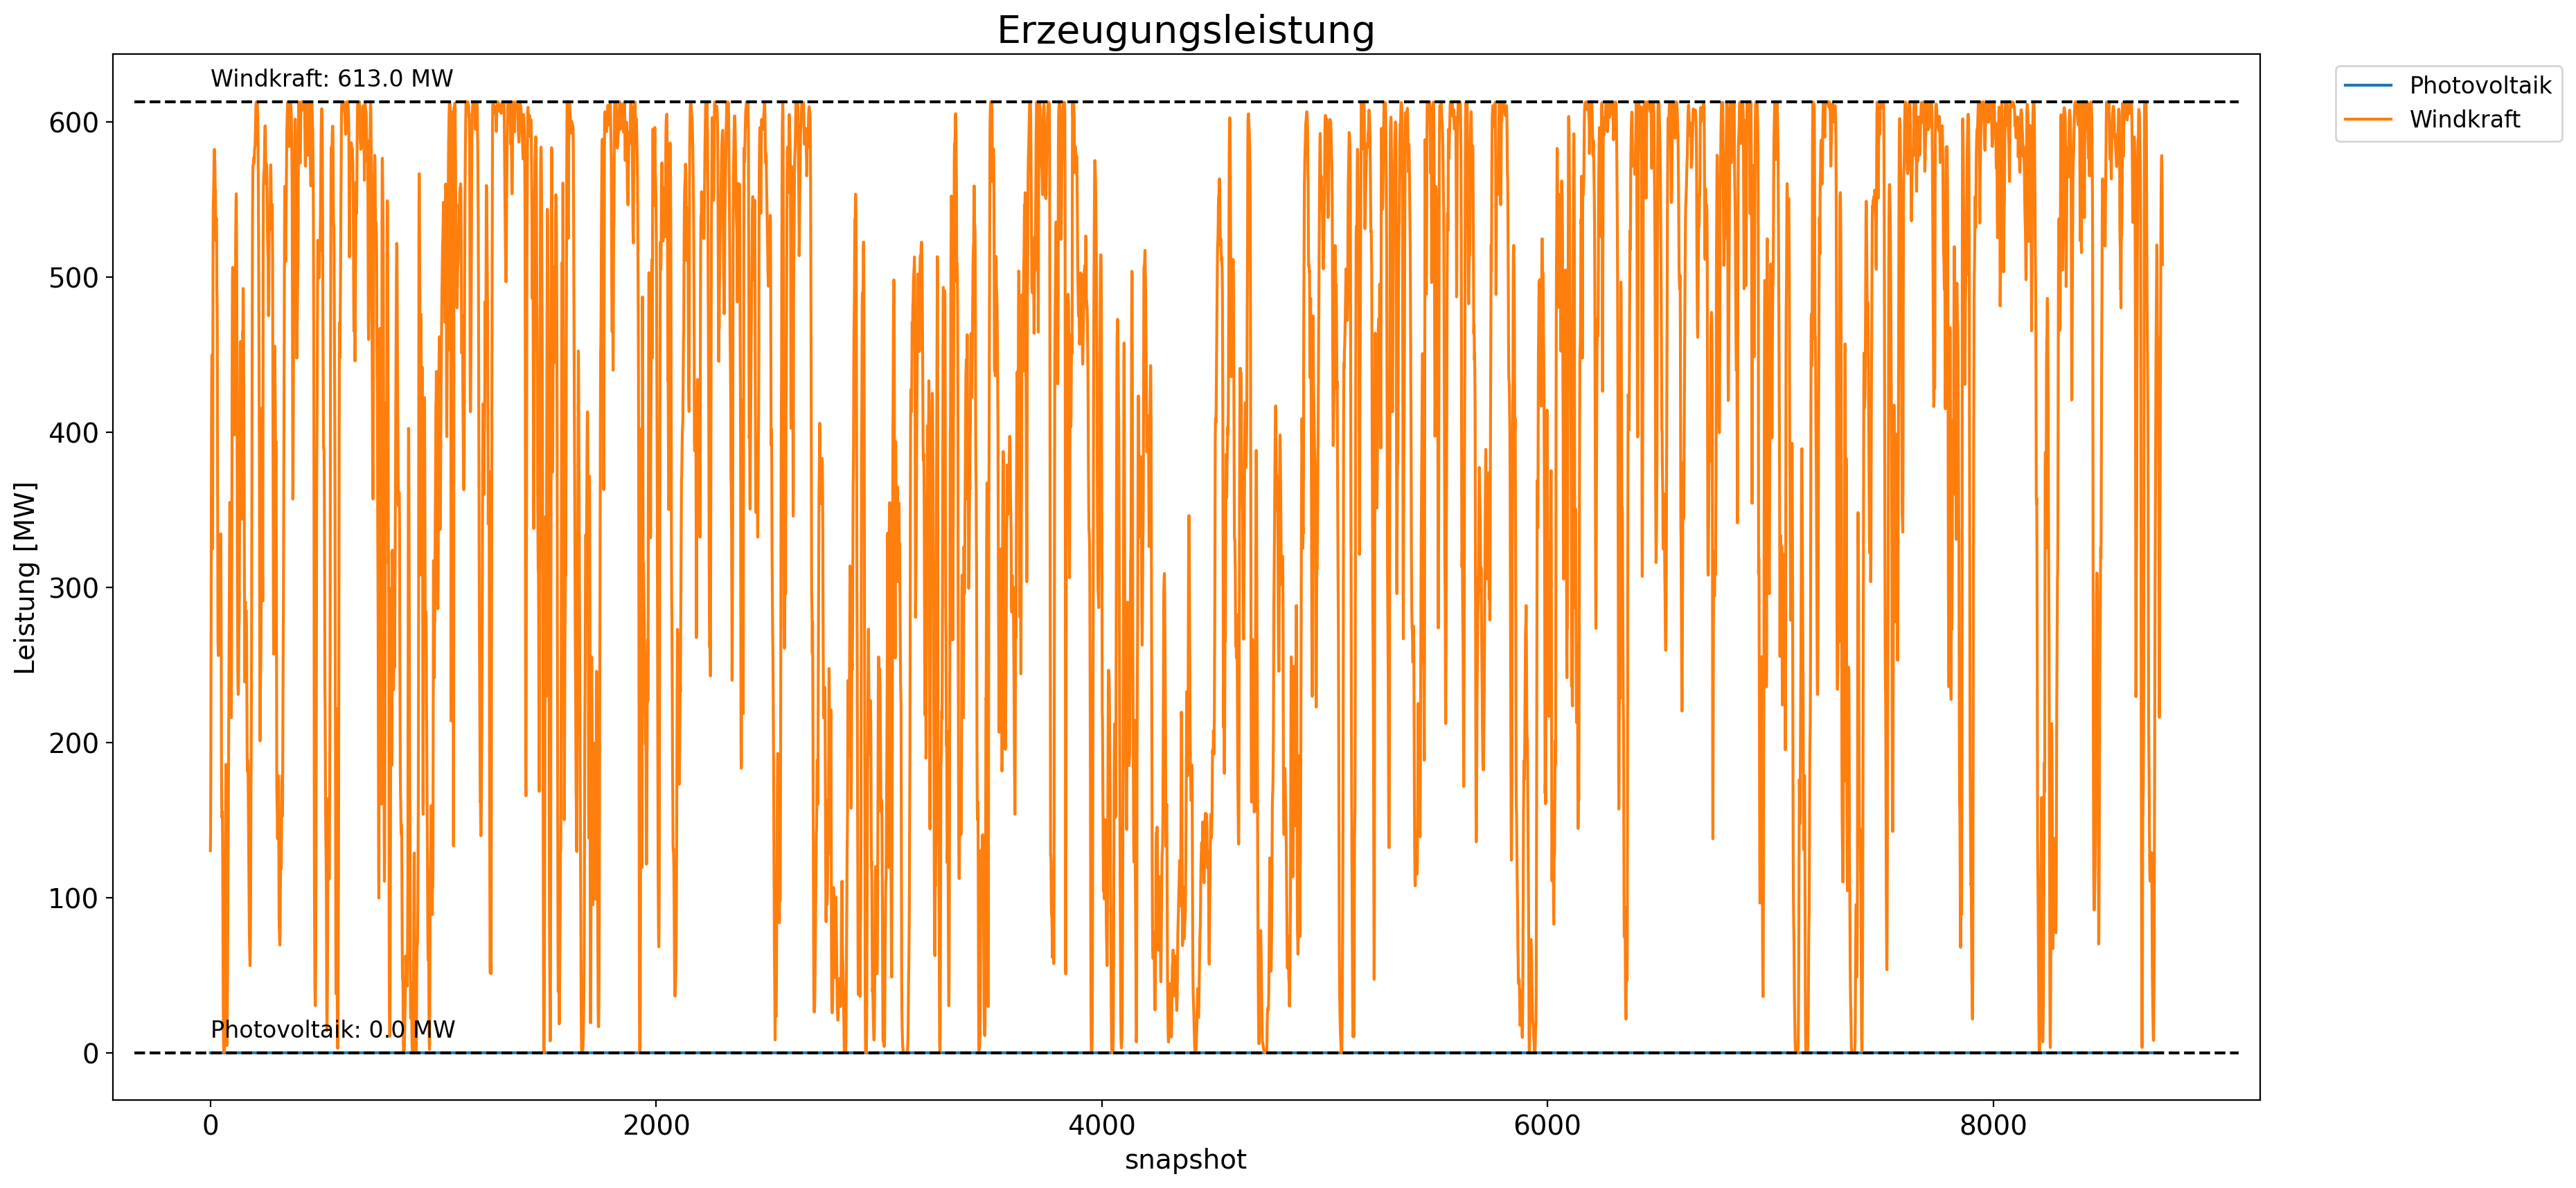

In [39]:
# Plot

ax = network1.generators_t.p.plot()

plt.axhline(y=network1.generators_t.p['Photovoltaik'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")
plt.axhline(y=network1.generators_t.p['Windkraft'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")

plt.text(s = 'Photovoltaik: '+str(network1.generators.p_nom_opt.round(0)['Photovoltaik'])+' MW' , y = network1.generators_t.p['Photovoltaik'].max() + 10, x = 0, color = 'black', fontsize = 12)
plt.text(s = 'Windkraft: '+str(network1.generators.p_nom_opt.round(0)['Windkraft'])+' MW', y = network1.generators_t.p['Windkraft'].max() + 10, x = 0, color = 'black', fontsize = 12)

ax.set_title('Erzeugungsleistung')
ax.set_ylabel("Leistung [MW]")
horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()                  

### Darstellung der optimierten Erzeugungsleistung als Jahresdauerline

In [40]:
#Dauerlinie(network1.generators_t,p,'Hi','Leistung')

### Darstellung der optimierten Elektrolyseleistung

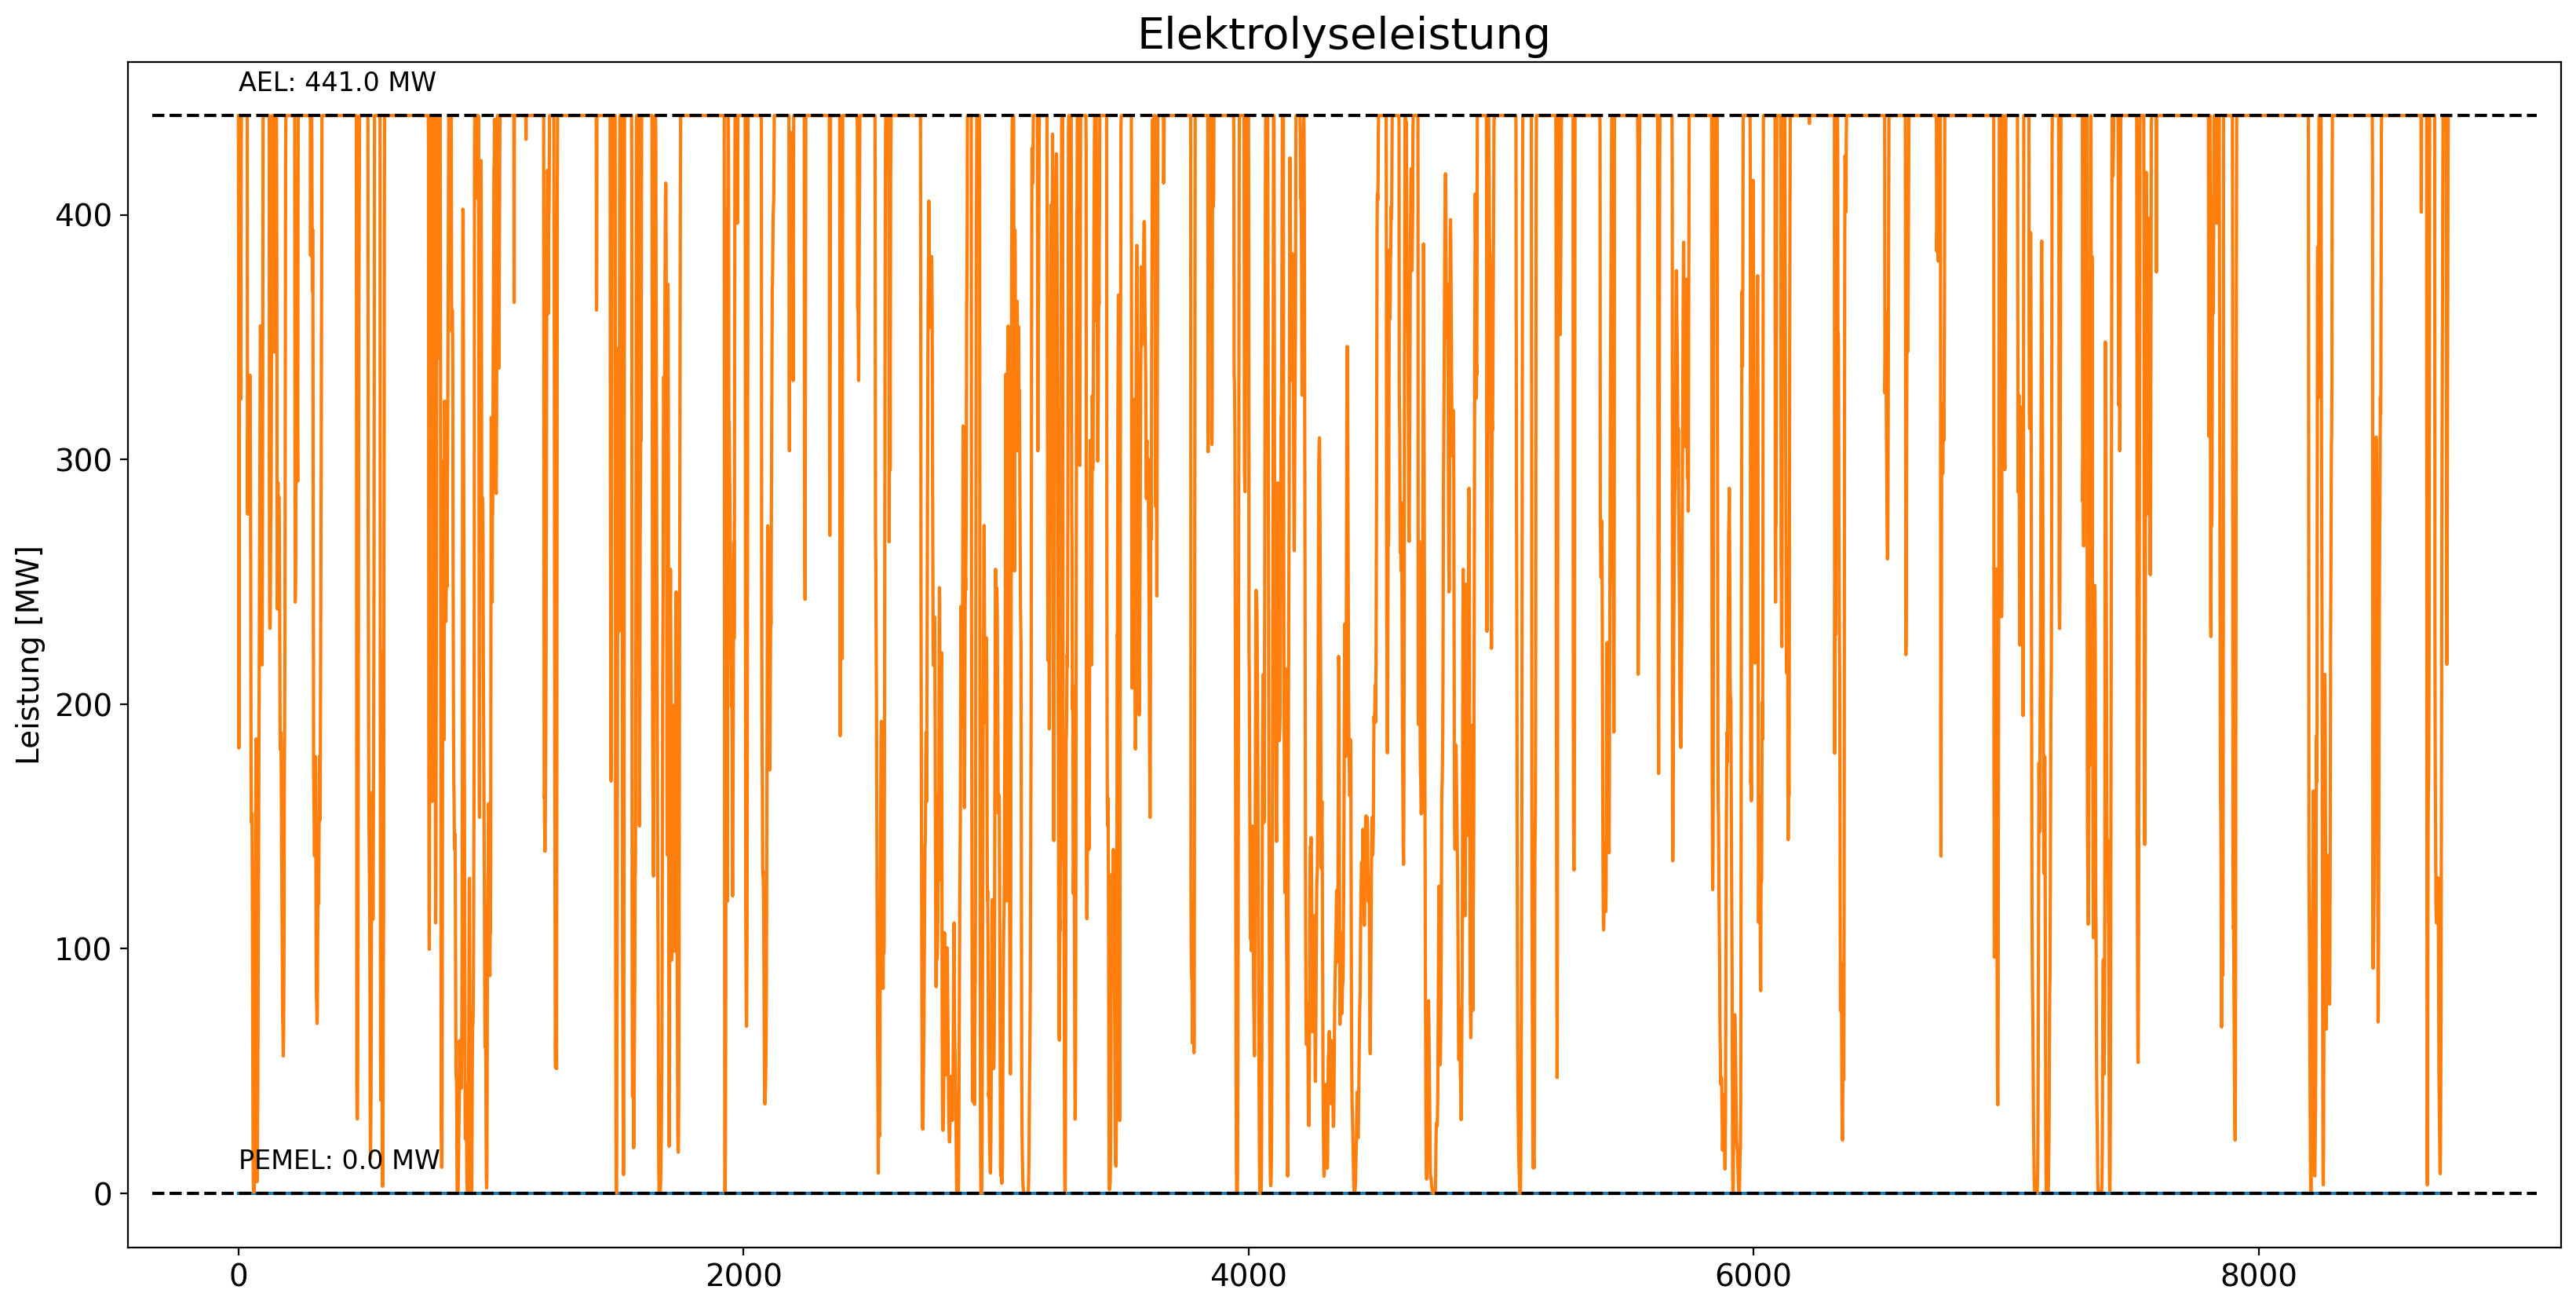

In [41]:
# Darstellung der optimierten Elektrolyseleistung

fig, ax = plt.subplots()

ax.plot(network1.links_t.p0['PEMEL'])
ax.plot(network1.links_t.p0['AEL'])
#ax.plot(network2.links_t.p0['AEL'])
#ax.plot(network3.links_t.p0['AEL'])

plt.axhline(y=network1.links_t.p0['PEMEL'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")
plt.axhline(y=network1.links_t.p0['AEL'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")

plt.text(s = 'PEMEL: '+str(network1.links.p_nom_opt.round(0)['PEMEL'])+' MW' , y = network1.links_t.p0['PEMEL'].max() + 10, x = 0, color = 'black', fontsize = 12)
plt.text(s = 'AEL: '+str(network1.links.p_nom_opt.round(0)['AEL'])+' MW', y = network1.links_t.p0['AEL'].max() + 10, x = 0, color = 'black', fontsize = 12)

ax.set_title('Elektrolyseleistung')
ax.set_ylabel("Leistung [MW]")
plt.show()         

### Darstellung der Bereitstellungskosten

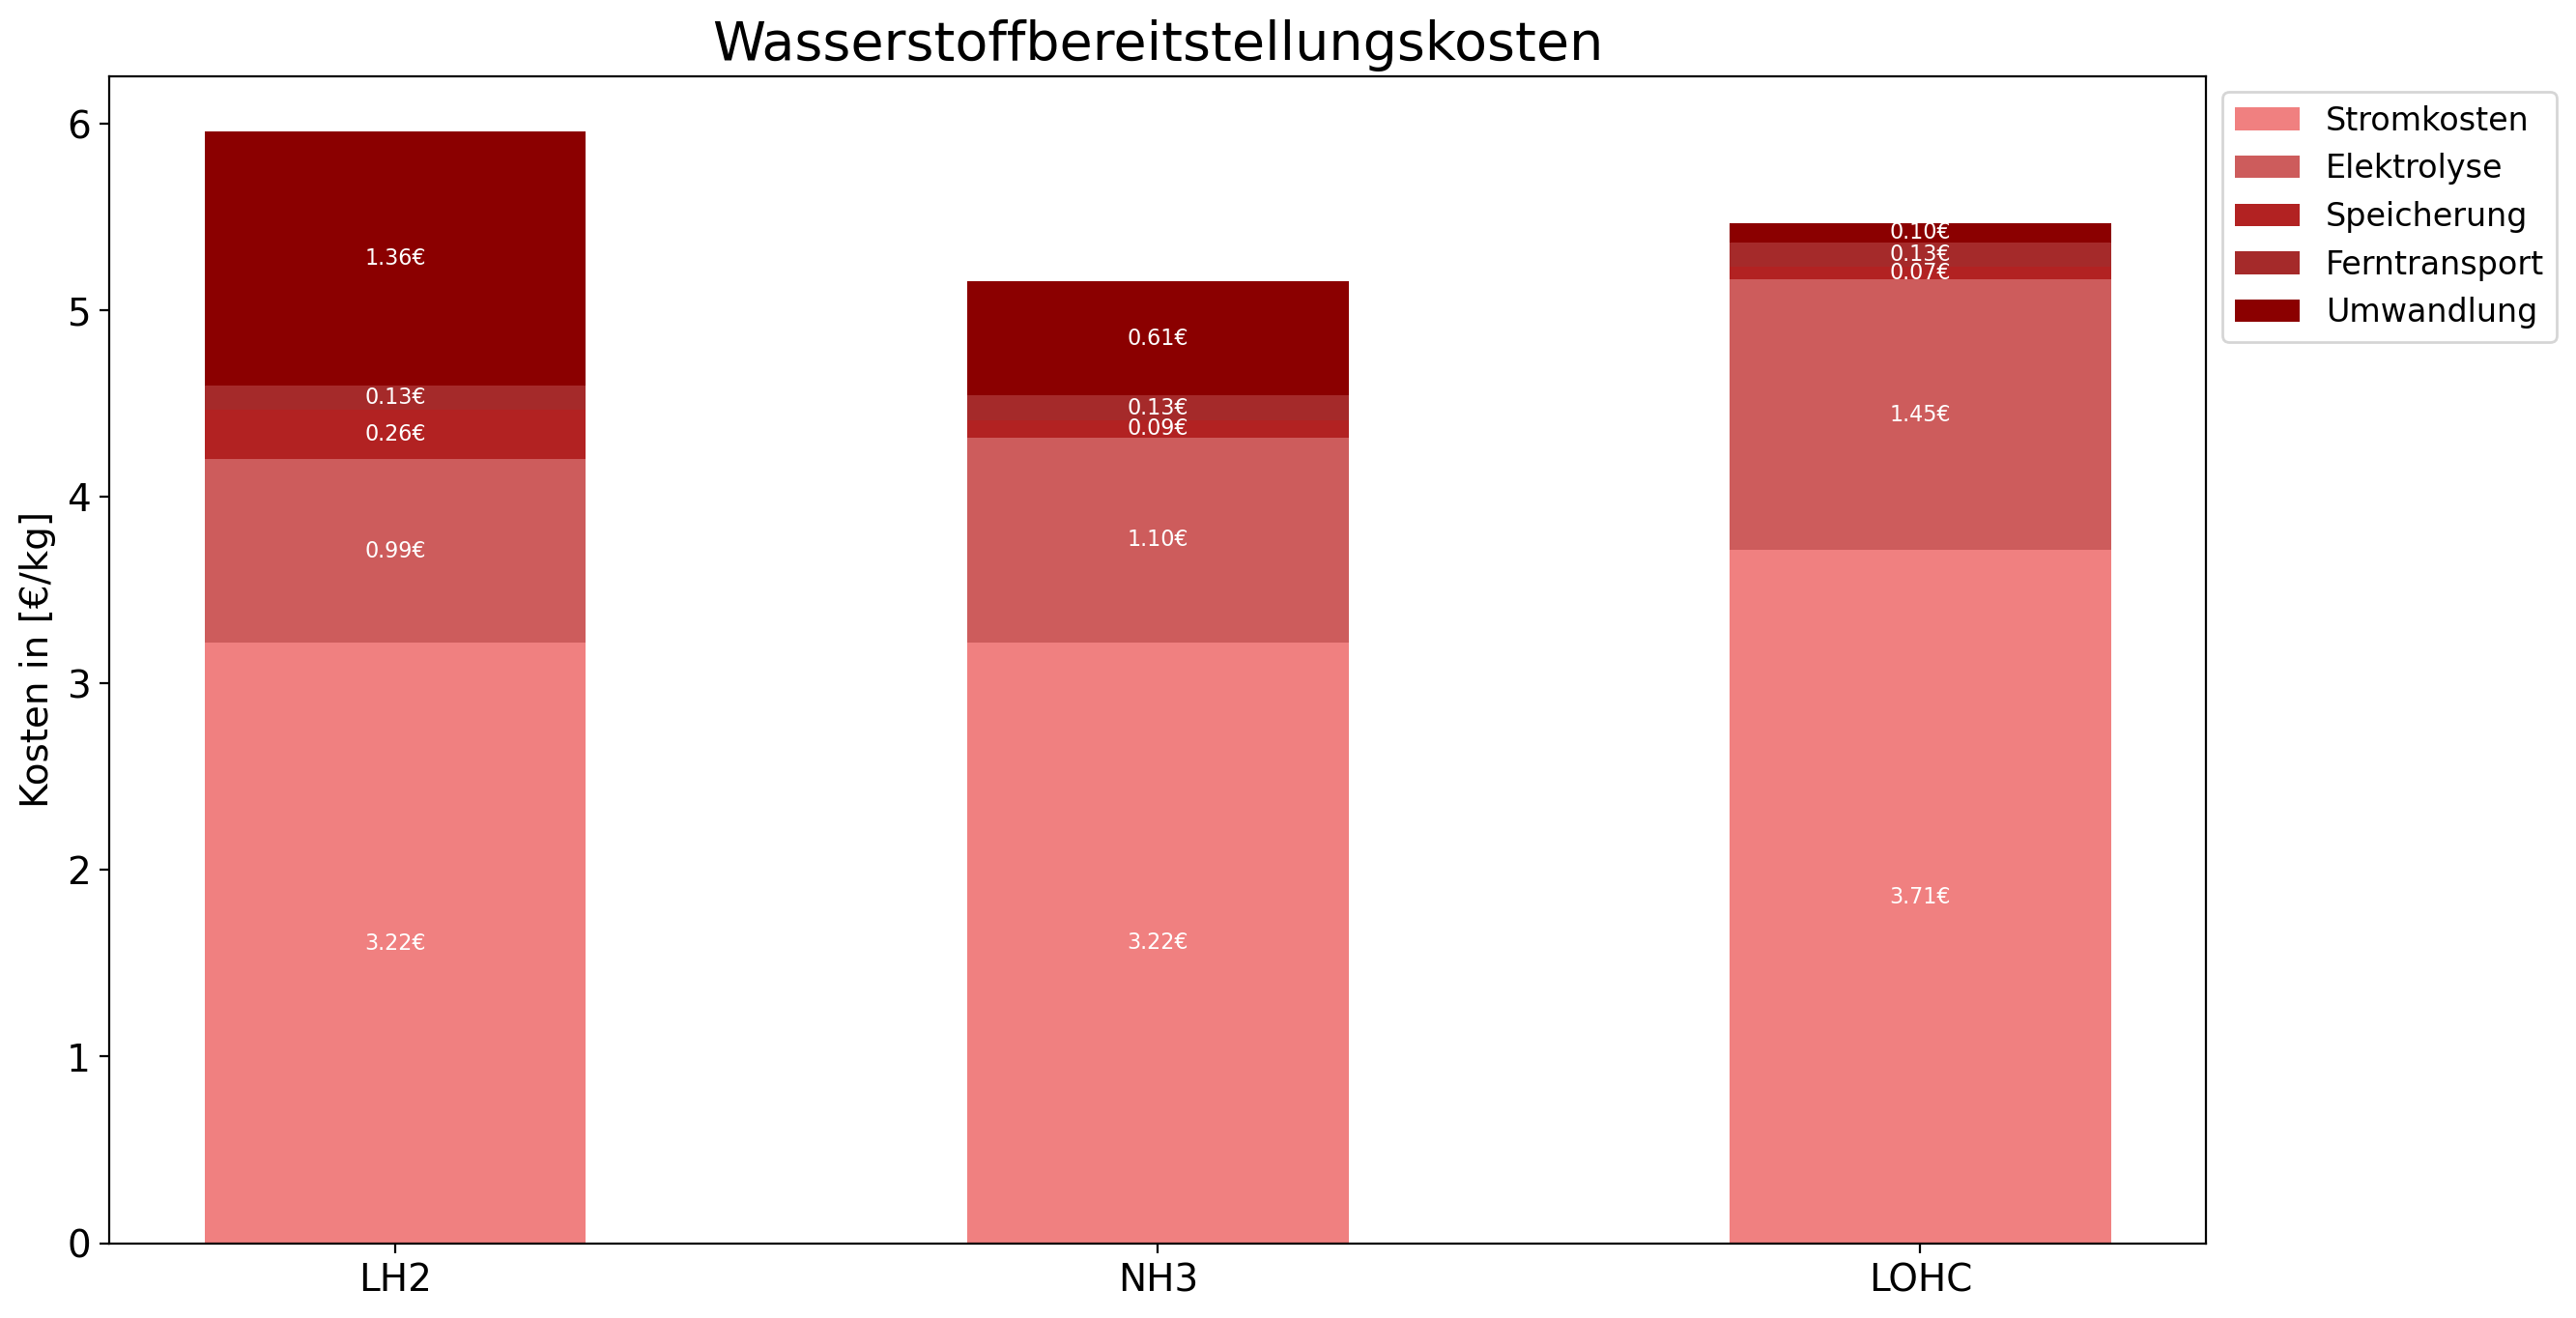

In [42]:
# Übersicht der Kilopreise

labels = ['LH2', 'NH3', 'LOHC']
Stromkosten = np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Stromkosten'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Stromkosten'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Stromkosten']])

Elektrolyse = np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Elektrolyse'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Elektrolyse'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Elektrolyse']])
                         
Umwandlung =  np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Umwandlung'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Umwandlung'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Umwandlung']])
                          
Ferntransport_1 = np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Transport'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Transport'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Transport']])

                         
Speicherung = np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Speicherung'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Speicherung'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Speicherung']])
# the width of the bars: can also be len(x) sequence
width=0.5
fig, ax = plt.subplots(figsize=(14,8))
#x_pos = [-2,0,2]
ax.bar(labels, Stromkosten, label='Stromkosten',width=width,color='lightcoral')
ax.bar(labels, Elektrolyse, bottom=Stromkosten,
       label='Elektrolyse',width=width,color='indianred')
ax.bar(labels, Speicherung, bottom=Stromkosten+Elektrolyse,
       label='Speicherung',width=width,color='firebrick')
ax.bar(labels, Ferntransport_1, bottom=Stromkosten+Elektrolyse+Speicherung,
       label='Ferntransport',width=width,color='brown')
ax.bar(labels, Umwandlung, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1,
       label='Umwandlung',width=width,color='darkred')

ax.set_ylabel('Kosten in [€/kg]')
ax.set_title('Wasserstoffbereitstellungskosten')
ax.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.02f}€'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=8,
            )
  

horiz_offset = 1.0
vert_offset = 1.0
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.xticks(x_pos, labels)
plt.show()

In [43]:
#Sankey Diagramm_BErechnungen_LH2

Input_Photovoltaik= results_sum_energy_1['Energie [GWh]']['Photovoltaik']/(results_sum_energy_1['Energie [GWh]']['Photovoltaik']+results_sum_energy_1['Energie [GWh]']['Windkraft'])
#Input_Photovoltaik= '{:.2%}'.format(Input_Photovoltaik)

Input_Windkraft= results_sum_energy_1['Energie [GWh]']['Windkraft']/(results_sum_energy_1['Energie [GWh]']['Photovoltaik']+results_sum_energy_1['Energie [GWh]']['Windkraft'])
#Input_Windkraft= '{:.2%}'.format(Input_Windkraft)
Verluste_AEL= -(1-(results_sum_energy_1['Energie [GWh]']['AEL']/(results_sum_energy_1['Energie [GWh]']['Photovoltaik']+results_sum_energy_1['Energie [GWh]']['Windkraft'])))
#Verluste_AEL= '{:.2%}'.format(Verluste_AEL)
Verluste_Verflüssigung= -(1-(results_sum_energy_1['Energie [GWh]']['Verflüssigung']/results_sum_energy_1['Energie [GWh]']['AEL']))
#Verluste_Verflüssigung= '{:.2%}'.format(Verluste_Verflüssigung)
Verluste_Verschiffung= -(1-(results_sum_energy_1['Energie [GWh]']['Verschiffung LH2']/results_sum_energy_1['Energie [GWh]']['Verflüssigung']))
Verluste_Regasifizierung= -(1-(results_sum_energy_1['Energie [GWh]']['Regasifizierung']/results_sum_energy_1['Energie [GWh]']['Verschiffung LH2']))
Verluste_Pipeline=  -(1-(results_sum_energy_1['Energie [GWh]']['Pipeline']/results_sum_energy_1['Energie [GWh]']['Regasifizierung']))
Last= -(1155/(results_sum_energy_1['Energie [GWh]']['Photovoltaik']+results_sum_energy_1['Energie [GWh]']['Windkraft']))

Verluste_Sankey = pd.DataFrame([Input_Photovoltaik, Input_Windkraft, Verluste_AEL,Verluste_Verflüssigung,Verluste_Verschiffung,Verluste_Regasifizierung,Verluste_Pipeline,Last],
                              columns=['Verluste'],
                            index=['Input_Photovoltaik', 'Input_Windkraft', 'Verluste_AEL','Verluste_Verflüssigung','Verluste_Verschiffung','Verluste_Regasifizierung','Verluste_Pipeline','Last'])
Verluste_Sankey.Verluste=Verluste_Sankey.Verluste*100
Verluste_Sankey = Verluste_Sankey.replace(0, np.nan)
Verluste_Sankey = Verluste_Sankey.dropna(how='all', axis=0)
Verluste_Sankey



,Verluste
Input_Windkraft,100.000000
Verluste_AEL,-46.879174
Verluste_Verflüssigung,-23.255902
Verluste_Verschiffung,-16.932706
Verluste_Regasifizierung,-2.441085
Last,-33.037474


ValueError: The shapes of 'flows' (6,) and 'orientations' (5,) are incompatible

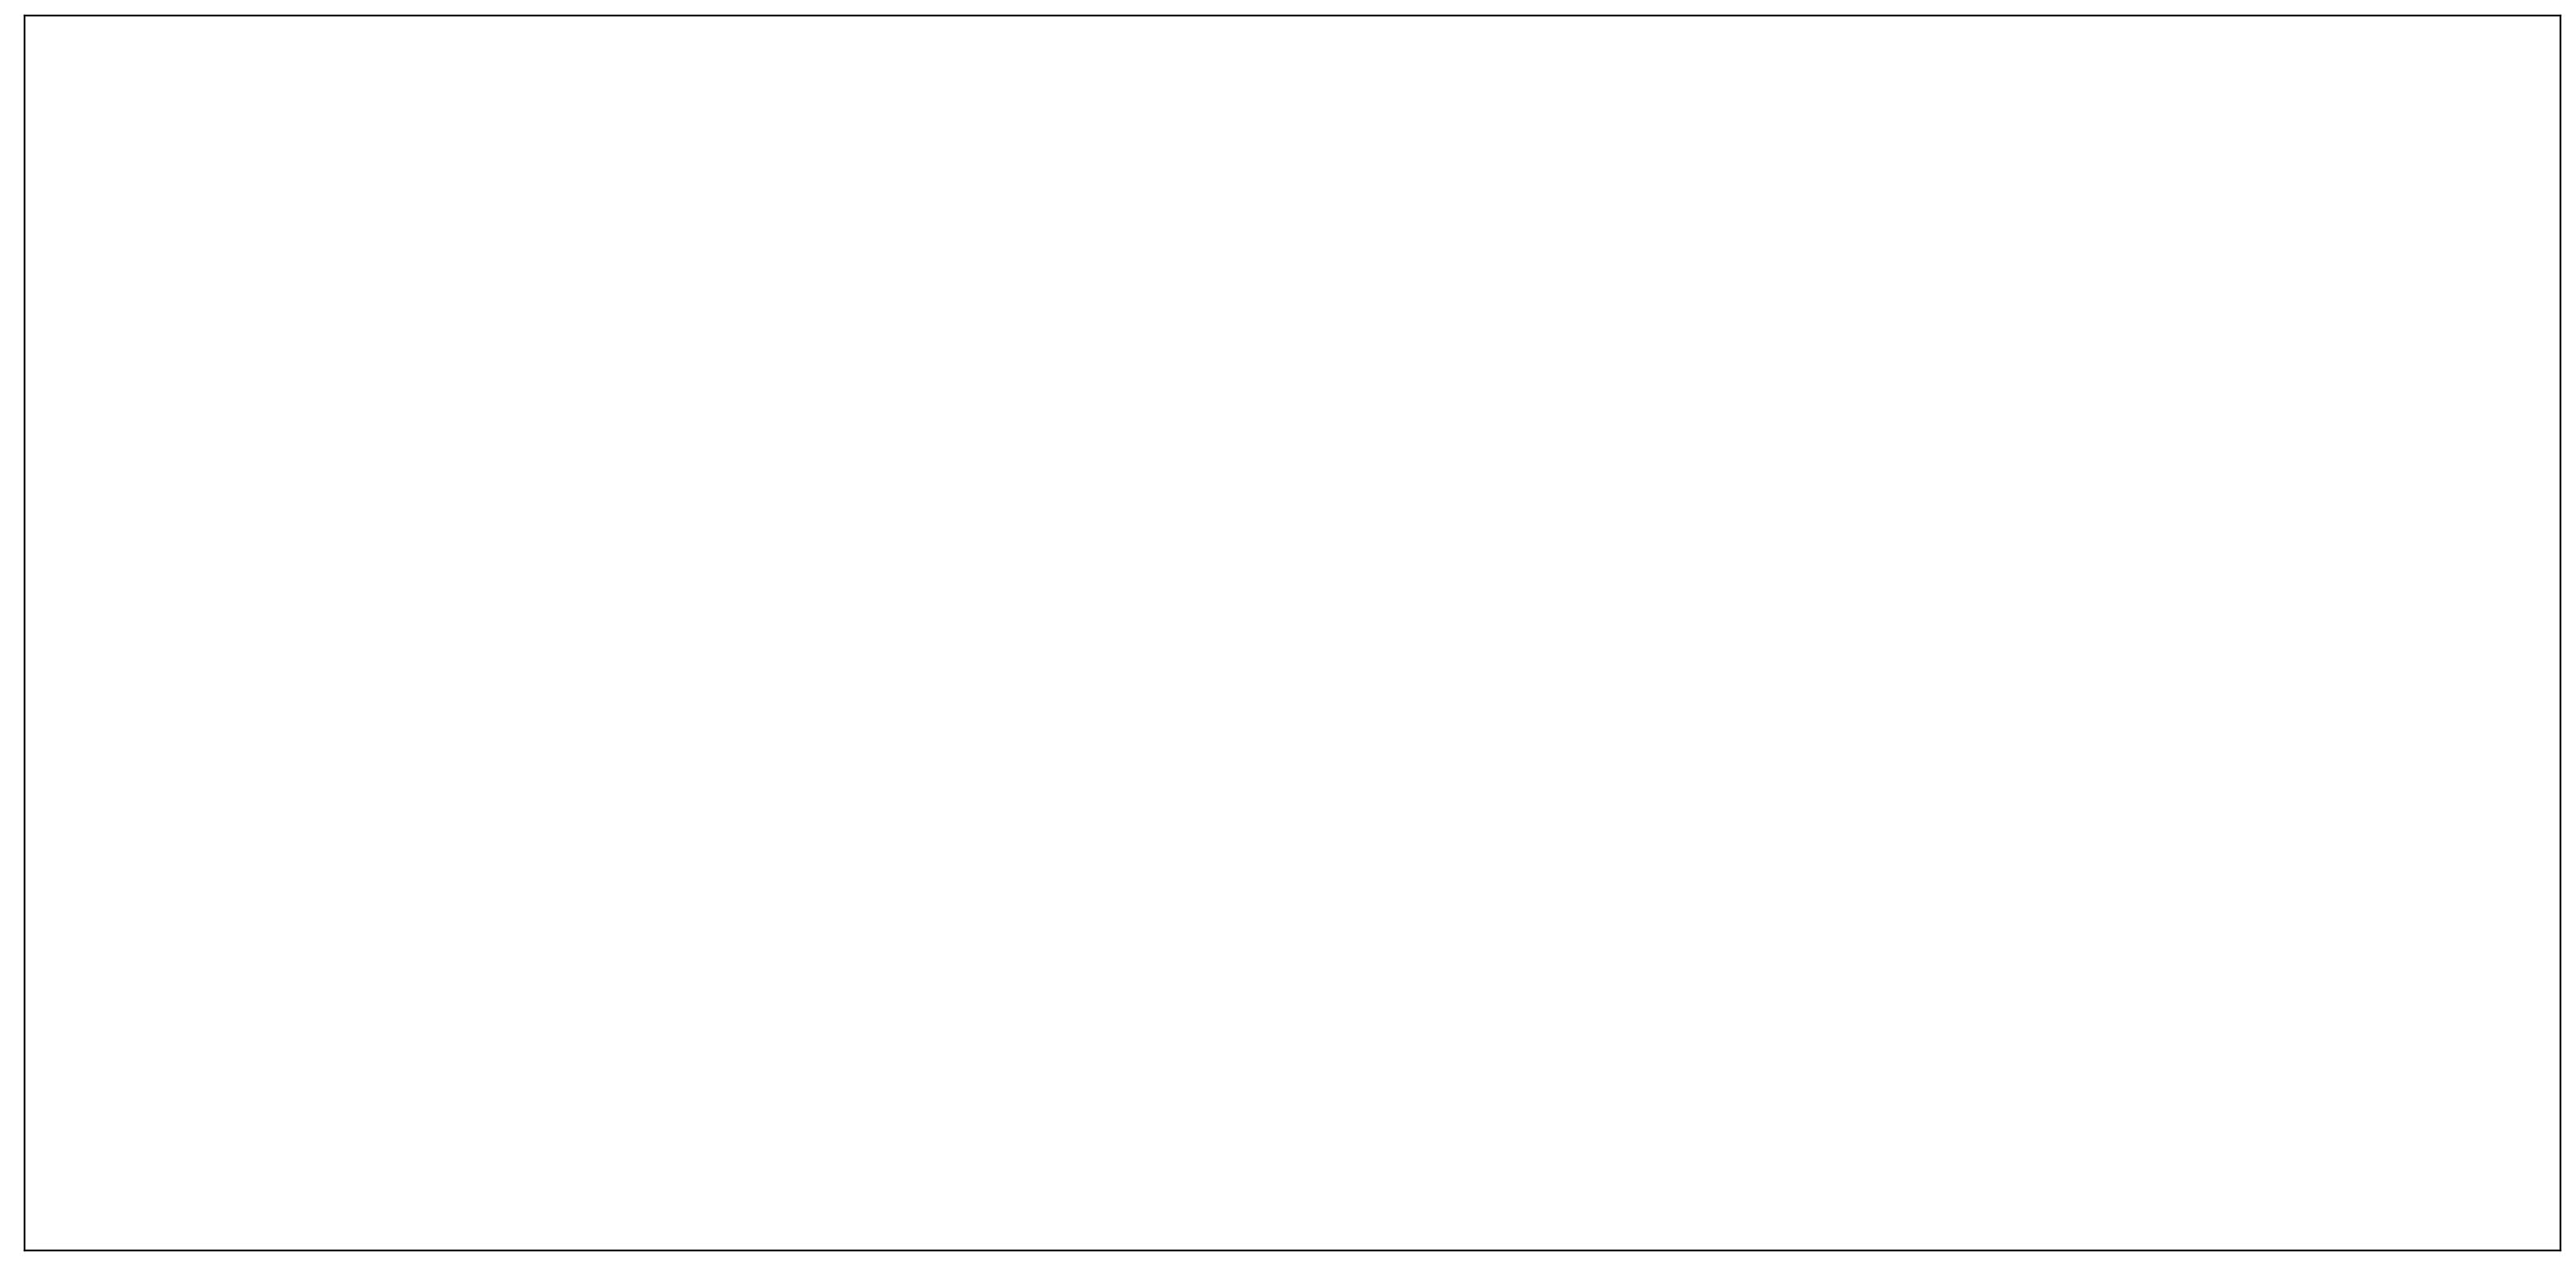

In [44]:
#Sankey Diagramm Verluste

from matplotlib.sankey import Sankey

sankey= Sankey(scale=0.01, offset=0.2,
                format='%.2f', unit='%')
sankey.add(flows=Verluste_Sankey.Verluste,labels=Verluste_Sankey.index,orientations=[0,-1,-1,-1,0],rotation=-90)
sankey.finish()

### Vergleich von Umwandlung und Ferntransport

In [ ]:
Betrachtungszeitraum = 10 # Tag(e)

In [ ]:
# Plot

a= (8760/9)*2
#b=a+Betrachtungszeitraum*24
b= (8760/9)*3

ax=network1.links_t.p0.loc[a:b].plot(ylabel = 'Leistung in MW')
horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()

### Vergleich von Speicherung und Ferntransport

In [ ]:
# Plot_AEL&PEM_ Speicher_und_Verschiffung

a=0
b=8760/9
fig, ax1 = plt.subplots(sharey = True)
Verschiffung_Tonnen=network1.links_t.p0['Verschiffung LH2']/hydrogen_energy_content
ax2 = ax1.twinx()
ax2.plot(Verschiffung_Tonnen.loc[a:b],
        label = 'Verschiffung LH2',color='red')
ax1.plot(network1.stores_t.e['Flüssigspeicher Chile'].loc[a:b]/hydrogen_energy_content,
        label = 'Flüssigspeicher Chile')
ax1.plot(network1.stores_t.e['Flüssigspeicher Bremerhaven'].loc[a:b]/hydrogen_energy_content,
        label = 'Flüssigspeicher Bremerhaven')
ax2.set_ylabel('Kapazität Verschiffung [t]')
ax1.set_ylabel('Kapazität Speicher [t]')


horiz_offset = 1.1
vert_offset = 0.90
fig.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()

# Werkstatt

In [ ]:
network1.stores_t.e.plot()